In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.interpolate import interp1d

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance # in kilometers

def calc_lrp_distance(df):
    # lrp before
    df_lrp_before = df.shift(1)
    
    # euclidean distance
    #lrp_distance = np.sqrt((df_lrp_before['lat'] - df['lat'])**2 + (df_lrp_before['lon'] - df['lon'])**2)

    # haversine distance
    lrp_distance = df.apply(lambda row: haversine(row['lat'], 
                                                  row['lon'], df_lrp_before.loc[row.name, 'lat'], 
                                                  df_lrp_before.loc[row.name, 'lon']), axis=1)

    return lrp_distance

def get_lrp_offroad(df, lrp_distance, q_threshold=0.85):
    threshold = lrp_distance.quantile(q_threshold)
    lrp_offroad = []

    for i in range(1, len(df) - 1):
        if lrp_distance.iloc[i] > threshold or lrp_distance.iloc[i + 1] > threshold:
            lrp_offroad.append(i)
    
    print(f'Found {len(lrp_offroad)} offroad LRP points')
    return lrp_offroad

def fix_offroad_lrp(df, lrp_offroad):
    i = 0
    while i < len(lrp_offroad):
        start = lrp_offroad[i] - 1
        end = lrp_offroad[i]
        while i + 1 < len(lrp_offroad) and lrp_offroad[i + 1] == lrp_offroad[i] + 1:
            end = lrp_offroad[i + 1]
            i += 1
        end += 1
        
        # Get the non-outlier points before and after the lrp_offroad
        lat_before = df.iloc[start]['lat']
        lon_before = df.iloc[start]['lon']
        lat_after = df.iloc[end]['lat']
        lon_after = df.iloc[end]['lon']
        
        # Interpolate using spline
        x = [start, end]
        lat_y = [lat_before, lat_after]
        lon_y = [lon_before, lon_after]
        
        lat_spline = interp1d(x, lat_y, kind='linear')
        lon_spline = interp1d(x, lon_y, kind='linear')
        
        for j in range(start + 1, end):
            df.at[j, 'lat'] = lat_spline(j)
            df.at[j, 'lon'] = lon_spline(j)
        
        i += 1
    return df

def process_offroad_lrp(df, q_threshold):

    lrp_distance = calc_lrp_distance(df)
    lrp_offroad = get_lrp_offroad(df, lrp_distance, q_threshold)
    fixed_df = fix_offroad_lrp(df, lrp_offroad)

    return fixed_df

def plot_road(df):
    plt.figure(figsize=(6, 4))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
     
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

def plot_roadname(df):
    plt.figure(figsize=(6, 4))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
        
    # Annotate each point with the 'lrp' label
    for i, row in df.iterrows():
        plt.annotate(row['lrp'], (row['lon'], row['lat']), textcoords="offset points", xytext=(0, 5), 
                     ha='center', fontsize=6, alpha=0.7)
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

def plot_map(df_rd):
    plt.figure(figsize=(10, 10))

    for idx, (road, group) in enumerate(df_rd.groupby('road')):
        plt.plot(group['lon'], group['lat'], 'o-', markersize=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

def plot_road_comparison(df_original, df_corrected, road):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot original road
    df_road_original = df_original[df_original['road'] == road]
    axes[0].scatter(df_road_original['lon'], df_road_original['lat'], color='y', alpha=0.7, label='lrp')
    axes[0].plot(df_road_original['lon'], df_road_original['lat'], color='k', alpha=1, linewidth=1, label='road')
    axes[0].set_title(f'{road} - Original')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].legend()
    
    # Plot corrected road
    df_road_corrected = df_corrected[df_corrected['road'] == road]
    axes[1].scatter(df_road_corrected['lon'], df_road_corrected['lat'], color='y', alpha=0.7, label='lrp')
    axes[1].plot(df_road_corrected['lon'], df_road_corrected['lat'], color='k', alpha=1, linewidth=1, label='road')
    axes[1].set_title(f'{road} - Interpolated')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

def transpose_original_tsv(df):
    # transposed df
    transposed_data = {
        'road': [],
        'lrp': [],
        'lat': [],
        'lon': []
    }

    # iterate over each row (each road)
    for index, row in df.iterrows():
        # iterate over the columns and extract the data
        for i in range(1, len(row), 3):
            if i + 2 < len(row):
                road = row.iloc[0]  # the road name is always in the first column
                lrp = row.iloc[i]
                lat = row.iloc[i + 1]
                lon = row.iloc[i + 2]

                # check for non-null values before appending
                if pd.notnull(lrp) and pd.notnull(lat) and pd.notnull(lon):
                    transposed_data['road'].append(road)
                    transposed_data['lrp'].append(lrp)
                    transposed_data['lat'].append(lat)
                    transposed_data['lon'].append(lon)

    # convert into df
    transposed_df = pd.DataFrame(transposed_data)
    # save to csv
    transposed_df.to_csv('../data/processed/road_transposed.csv', index=False)
    
    return transposed_df

def transpose_data_to_tsv(db):
    # Create a new column for the position of each LRP, LAT, and LON
    db['position'] = db.groupby('road').cumcount() + 1

    # Pivot the DataFrame
    pivoted_df = db.pivot(index='road', columns='position', values=['lrp', 'lat', 'lon'])

    # Flatten the MultiIndex columns and rename them
    pivoted_df.columns = [f'{col[0]}_{col[1]}' for col in pivoted_df.columns]

    # Reset the index to make 'road' a column again
    pivoted_df.reset_index(inplace=True)
    pivoted_df

    #Reorder the columns to ensure the order is lrp1, lat1, lon1, lrp2, lat2, lon2, etc.
    ordered_columns = []
    max_position = db['position'].max()
    for i in range(1, max_position + 1):
        ordered_columns.extend([f'lrp_{i}', f'lat_{i}', f'lon_{i}'])

    # Select the columns in the desired order
    pivoted_df = pivoted_df[['road'] + ordered_columns]

    # Save the pivoted DataFrame to a TSV file
    pivoted_df.to_csv('../data/processed/_roads.tsv', sep='\t', index=False)

    return pivoted_df

# Example usage
# Load the data and transpose it
df_road = pd.read_csv('../data/raw/_roads.tsv', sep='\t', low_memory=False)
df = transpose_original_tsv(df_road)
roads = df['road'].unique()

# Make a copy of the original data before fixing
df_rd_original = df.copy()

# first iteration
quantile_1 = 0.85
# calculate threshold and interpolate per road
for road in roads:
    df_road = df[df['road'] == road].reset_index(drop=True)
    lrp_distance = calc_lrp_distance(df_road)
    lrp_offroad = get_lrp_offroad(df_road, lrp_distance, q_threshold=quantile_1)

    print(f"Outliers for road {road}: {lrp_offroad}")  # Debug print statement
    df_road_corrected = fix_offroad_lrp(df_road, lrp_offroad)
    df.loc[df['road'] == road, ['lat', 'lon']] = df_road[['lat', 'lon']].values

# second iteration
qunatile_2 = 0.95
# calculate threshold and interpolate per road
for road in roads:
    df_road = df[df['road'] == road].reset_index(drop=True)
    lrp_distance = calc_lrp_distance(df_road)
    lrp_offroad = get_lrp_offroad(df_road, lrp_distance, q_threshold=qunatile_2)

    print(f"Outliers for road {road}: {lrp_offroad}")  # Debug print statement
    df_road_corrected = fix_offroad_lrp(df_road, lrp_offroad)
    df.loc[df['road'] == road, ['lat', 'lon']] = df_road[['lat', 'lon']].values

df.to_csv('../data/processed/_roads_cleaned.csv', index=False)
transpose_data_to_tsv(df)

Found 343 offroad LRP points
Outliers for road N1: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 30, 31, 32, 33, 34, 53, 54, 60, 61, 62, 63, 64, 65, 68, 69, 70, 92, 93, 99, 100, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 123, 124, 127, 128, 131, 132, 134, 135, 136, 137, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 153, 154, 155, 157, 158, 160, 161, 162, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 188, 189, 190, 191, 192, 193, 198, 199, 200, 205, 206, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 226, 227, 232, 233, 234, 237, 238, 240, 241, 252, 253, 254, 255, 260, 261, 267, 268, 277, 278, 279, 280, 289, 290, 297, 298, 303, 304, 316, 317, 323, 324, 332, 333, 338, 339, 340, 342, 343, 346, 347, 348, 349, 350, 352, 353, 354, 355, 357, 358, 359, 364, 365, 366, 367, 378, 379, 380, 381, 385, 386, 387, 398, 399, 400, 401, 406, 407, 410, 411, 421, 422, 425, 426, 427, 428, 429, 430, 442, 443, 463, 464, 466, 467, 47

,road,lrp_1,lat_1,lon_1,lrp_2,lat_2,lon_2,lrp_3,lat_3,lon_3,...,lon_1345,lrp_1346,lat_1346,lon_1346,lrp_1347,lat_1347,lon_1347,lrp_1348,lat_1348,lon_1348
0,N1,LRPS,23.706028,90.443333,LRPSa,23.704403,90.446903,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.458542,91.212333,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961555,91.114213,LRP001a,23.966083,91.112898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.39525,LRP001,23.009361,91.390287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,Z8910,LRPS,22.674722,90.408889,LRPSa,22.675916,90.412556,LRP001,22.674972,90.417889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873,Z8913,LRPS,22.396083,90.688666,LRPSa,22.393027,90.688944,LRPSb,22.392666,90.689083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,Z8915,LRPS,22.589389,90.619472,LRP001,22.589694,90.62336,LRP001a,22.590027,90.63136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875,Z8916,LRPS,22.625499,90.661722,LRPSa,22.623888,90.664167,LRP001,22.622948,90.668565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


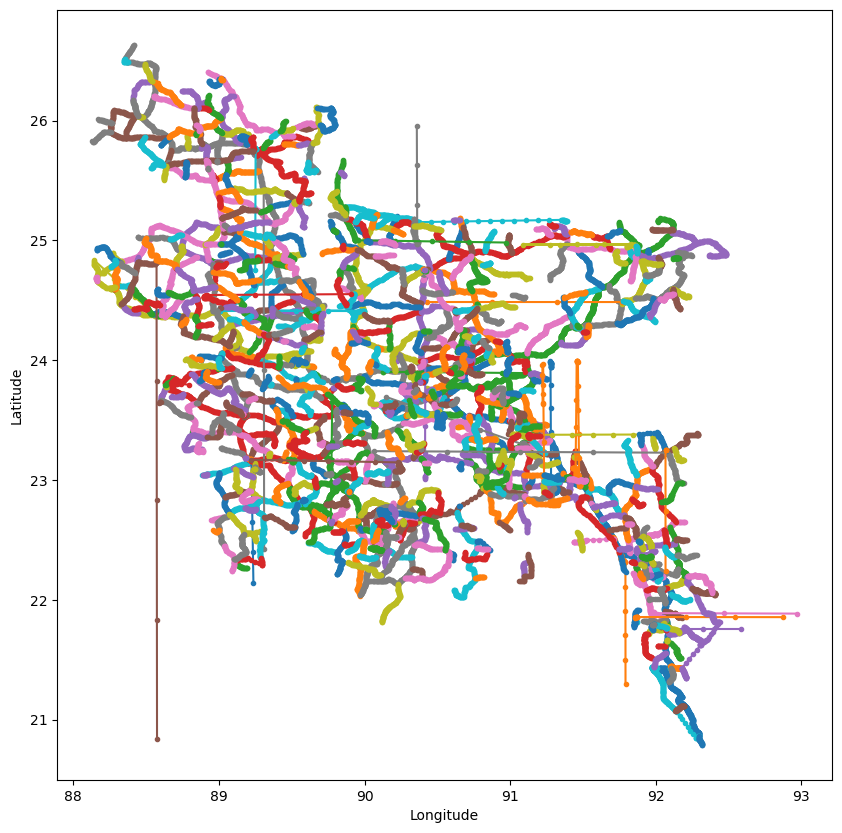

In [5]:
plot_map(df)

In [6]:
#for road in roads:
 #   plot_road_comparison(df_rd_original, df, road)